# Object detection model

> Object Detection Model


- skip_showdoc: true
- skip_exec: true

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()
###################################################

## KITTI

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import models, datasets, tv_tensors, transforms
from torchvision.transforms import v2, ToPILImage
from torchvision.datasets import Kitti, VisionDataset

import torch.utils.data
from torch.utils.data import DataLoader


In [ ]:
from tqdm import tqdm
import cv2
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
class Kitti_v2(Kitti):
    def __init__(self, *args, **kwargs):
        super(Kitti_v2, self).__init__(*args, **kwargs)

In [ ]:
torch.manual_seed(0)

<torch._C.Generator>

In [ ]:
path = './Data'

desired_size = (round(375), round(1242))
# desired_size = (250, 500)

In [ ]:
transform2 = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(size = desired_size),  # Resize image
        v2.RandomPhotometricDistort(p=0.2),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # # v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=0.4),
        # # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
# Load KITTI train dataset
train_dataset = Kitti_v2(root=path, train='true', download=True, transforms=transform2)

# Load KITTI test dataset
test_dataset = Kitti_v2(root=path, train='false', download=True, transforms=transform2)

In [ ]:
sample = train_dataset[1000]
img, target = sample
print(f"{type(img) = }\n{type(target) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'list'>


In [ ]:
train_dataset2 = datasets.wrap_dataset_for_transforms_v2(train_dataset, target_keys=("boxes", "labels"))

test_dataset2 = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels"))

In [ ]:
sample = train_dataset2[1000]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>


In [ ]:
def cv2_show(image_np, label):
    image_cv2 = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    for bbox, item in zip(label['boxes'], label['labels']):
        # Draw the bounding box
        cv2.rectangle(image_cv2, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
    
        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_cv2, str(item), (int(bbox[0]), int(bbox[1]) - 10), font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    
    return image_rgb

def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(math.sqrt(len(images)))
    ncols = int(np.floor(len(images)/nrows))
        
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    # Display the image using Matplotlib
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = image.numpy().transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        
        # Display image
        ax.imshow(image_rgb)
        ax.axis('off')

    for ax in axes.flat[len(images):]:
        ax.axis('off')
    plt.show()

In [ ]:
image,_ = train_dataset2[18]
image.shape

torch.Size([3, 375, 1242])

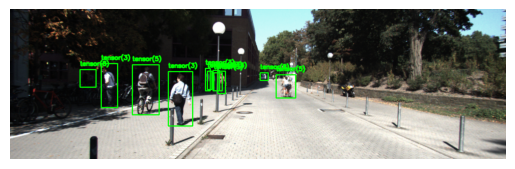

In [ ]:
show_image(train_dataset2[18])

In [ ]:
batch_size = 8

train_loader = DataLoader(train_dataset2,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)),
                          num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset2,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)


In [ ]:
type(images)

tuple

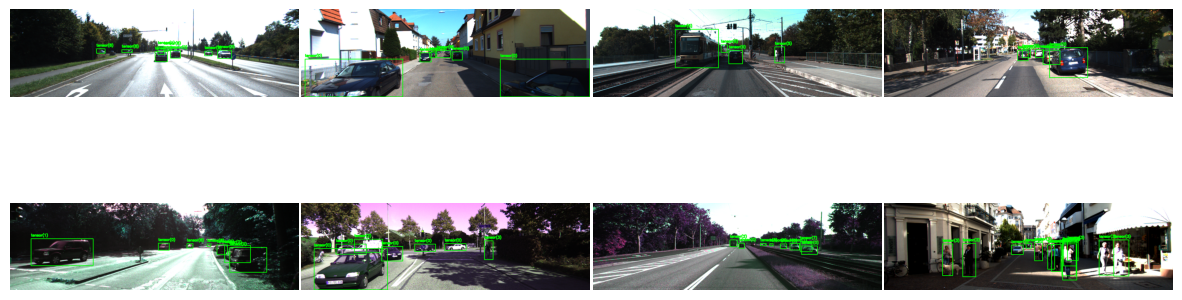

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
# Define a function to display images
def board_images(images, labels, **kwargs):
    new_images = []
    for image, label in zip(images, labels):
        # Convert image to numpy array and adjust pixel values
        image_np = image.numpy().transpose((1, 2, 0))
        image_rgb = cv2_show(image_np, label)
        new_images.append(image_rgb)
    return new_images


In [ ]:
new_images = board_images(images, labels)
tensor = torch.stack([torch.tensor(array) for array in new_images])


In [ ]:
tensor[1].shape

torch.Size([375, 1242, 3])

In [ ]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(list(images))
img_grid

writer.add_image('KITTI_images', img_grid)
writer.flush()
#sys.exit()
###################################################

### Model

In [ ]:
import torch 
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.transform import GeneralizedRCNNTransform


In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Define the resize parameters
min_size = (300,)  # Change this to your desired minimum size
max_size = 500    # Change this to your desired maximum size

# Define the transform
transform3 = GeneralizedRCNNTransform(
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225],
    min_size=min_size,
    max_size=max_size
)

In [ ]:
# Load the ResNet-18 backbone
backbone = resnet_fpn_backbone('resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

# Create the Faster R-CNN model with the modified transform
model = FasterRCNN(backbone, num_classes=20, transform=transform3)
model.transform.min_size = min_size
model.transform.max_size = max_size

/home/ben/mambaforge/envs/pfast/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(300,), max_size=500, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [ ]:
# Define an optimizer (you can use any optimizer from torch.optim)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            momentum=0.9)
# Define optimizer and learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

epochs = 1


In [ ]:
len(train_loader)

936

In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for imgs, targets in tqdm(train_loader):
        # Move input data to GPU
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
    
    # Update learning rate scheduler
    lr_scheduler.step()
    
    # Print average loss for the epoch
    print(f"Average Loss: {total_loss / len(train_loader):.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████| 936/936 [07:04<00:00,  2.20it/s]

Average Loss: 0.7411


In [ ]:
# Evaluation loop
model.train()
total_loss = 0.0

with torch.no_grad():
    for imgs, targets in tqdm(test_loader):
        # Move input data to GPU
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        total_loss += losses.item()

# Print average loss for the evaluation
print(f"Average Loss (Evaluation): {total_loss / len(test_loader):.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████| 936/936 [04:48<00:00,  3.24it/s]

Average Loss (Evaluation): 0.6427


In [ ]:
model.eval()
# Get a batch of images and labels from the data loader
examples = iter(test_loader)

In [ ]:
images, labels = next(examples)
imgs = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

In [ ]:
len(imgs)

8

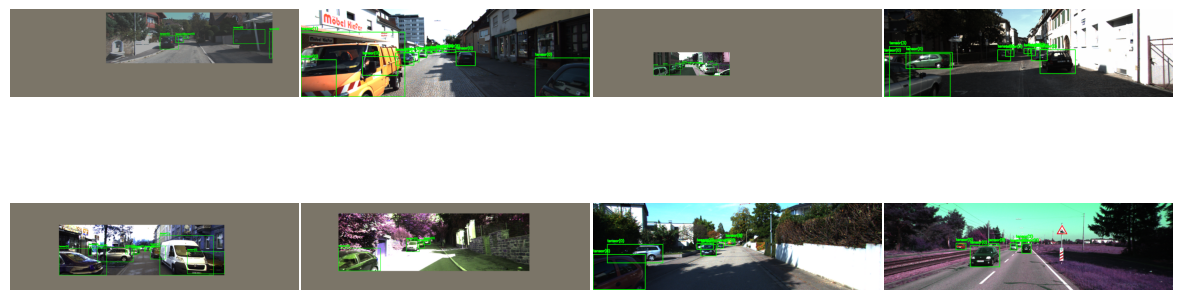

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
type(labels)

tuple

In [ ]:
loss_dict = model(imgs)

In [ ]:
loss_dict[1]

{'boxes': tensor([[169.4477,  92.3150, 484.5056, 375.0000],
         [ 68.4527,  68.5218, 368.3462, 344.3433],
         [ 85.0003,  46.8121, 493.6891, 269.8161],
         [ 20.8630,  20.1675, 317.5098, 300.3821],
         [505.8318, 176.1425, 543.8195, 203.9862],
         [ 30.1487,  68.1431, 321.2308, 342.8820],
         [340.6010, 162.4555, 434.3331, 362.9965],
         [181.4230,  95.5453, 489.8918, 365.5621],
         [  0.0000, 121.2051,  53.4617, 326.8895],
         [  0.0000, 167.0646, 115.2387, 282.0323],
         [ 61.3802,  59.3385, 374.3310, 352.1205],
         [519.3469, 174.9075, 547.6403, 197.0541]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 7, 8, 3, 3, 7, 1, 1, 8, 8], device='cuda:0'),
 'scores': tensor([0.1210, 0.1147, 0.0895, 0.0662, 0.0620, 0.0557, 0.0548, 0.0544, 0.0533,
         0.0527, 0.0518, 0.0501], device='cuda:0', grad_fn=<IndexBackward0>)}

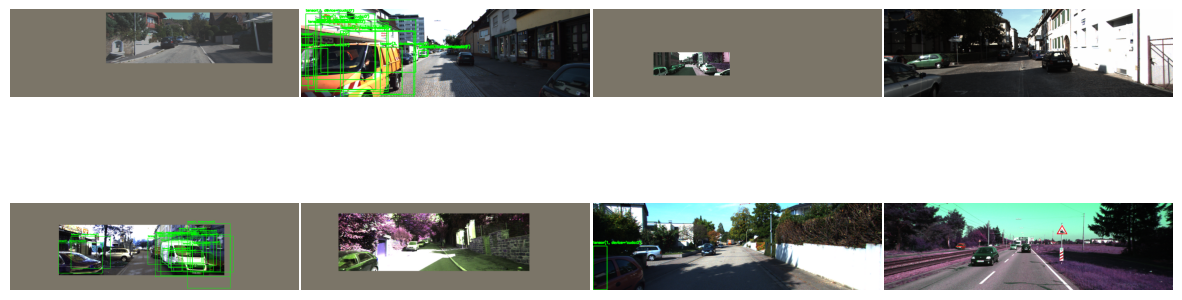

In [ ]:
show_images(images, loss_dict, figsize=(15, 5))